# **Connect Google Drive**

In [ ]:
!nvidia-smi

Sat Dec 16 11:52:00 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Environment Setup**

## Install `torchmetrics`

In [ ]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 4.5 MB/s eta 0:00:00


## Install `portalocker`

In [ ]:
!pip install -q portalocker>=2.0.0

## Install `wandb`

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00


# **Don't forget to restart the runtime!**

# **Import Libs**

In [ ]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2 as cv
import PIL
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

from torch import optim
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import tqdm
import re

from collections import defaultdict
from typing import Any, Callable, Dict, List, Optional, Tuple

In [ ]:
!python --version

Python 3.10.12


In [ ]:
for lib in [np, torch, torchtext, torchvision, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.23.5
torch --> 2.1.0+cu118
torchtext --> 0.16.0+cpu
torchvision --> 0.16.0+cu118
tqdm --> 4.66.1


# **Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [ ]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      # torch.cuda.manual_seed_all(seed)

      # torch.backends.cudnn.deterministic = True
      # torch.backends.cudnn.benchmark = False


# **Arguments**

In [ ]:
seed = 8

batch_size = 128


embed_size = 300
hidden_size = 500
num_layers = 2
dropout_embd = 0.5
dropout_rnn = 0.5
max_seq_length = 20

clip = 0.25

lr = 0.1
momentum = 0.9
wd = 1e-4

wandb_enable = False

In [ ]:
if wandb_enable:
    wandb_arg_name = input('Please input the WandB argument (run) name:')
    print(wandb_arg_name)

## 🟠 Change the font size of the output cells

In [ ]:
# print('Salam Howsam!')

In [ ]:
# from IPython.display import HTML
# shell = get_ipython()

# def adjust_font_size():
#   display(HTML('''<style>
#     body {
#       font-size: 24px;
#     }
#   '''))

# if adjust_font_size not in shell.events.callbacks['pre_execute']:
#   shell.events.register('pre_execute', adjust_font_size)

In [ ]:
# print('Salam Howsam!')

# **Dataset**

## Load the Dataset

In [ ]:
!unzip -q $'/content/drive/MyDrive/project_2_image_caption/Dataset/Flickr8k_text.zip' -d '/content/text'
!unzip -q '/content/drive/MyDrive/project_2_image_caption/Dataset/Flickr8k_Dataset.zip' -d '/content/image'

## EDA

### Let's explore the images and captions in the Flicker8k dataset together!

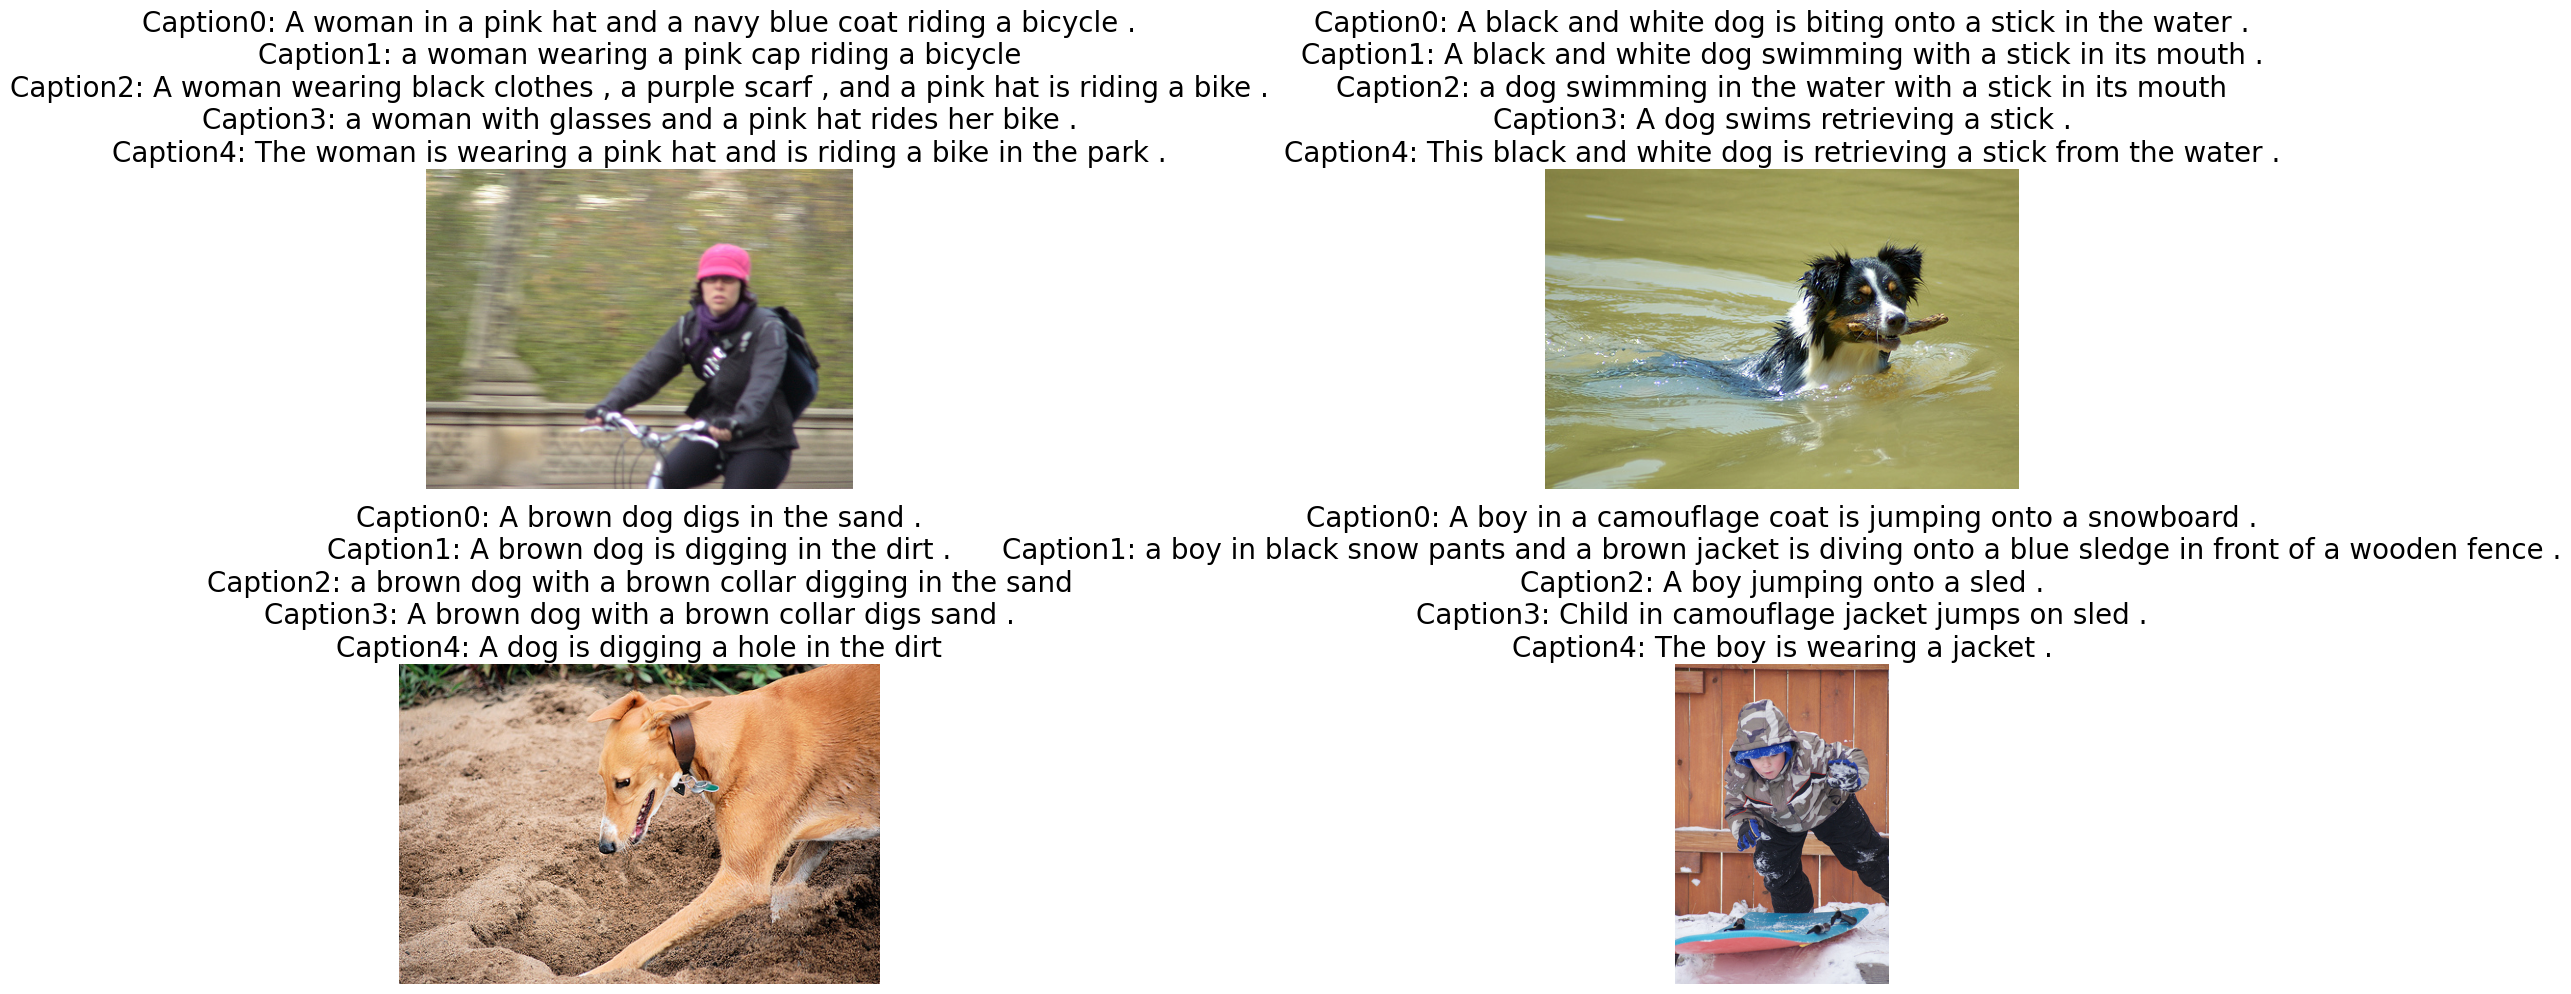

In [ ]:
from operator import index
# Replace with the actual path to your UTK dataset images folder
image_path1 = '/content/image/Flicker8k_Dataset/'
dataset_folder = '/content/text/Flickr8k.token.txt'

def show_random_samples(num_samples=4):
    image_name = []
    caption = []
    image_files = open(dataset_folder)
    lines = image_files.readlines()
    for line in lines:
      line = line.strip()
      parts = re.split('\t', line)
      image_n =  (re.split('#', parts[0])[0])
      image_name.append(image_n)
      caption.append(parts[1])

    selected_image_files = random.sample(image_name, num_samples)

    plt.figure(figsize=(23, 15))
    for idx, image_file in enumerate(selected_image_files, 1):
      #Read Image
      image_path = os.path.join(image_path1, image_file)
      image = Image.open(image_path)
      #Read Caption
      target_cap = image_name.index(image_file)
      titles = []
      for i in range(5):

        t = target_cap + i
        cap_file = caption[t]
        titles.append(cap_file)
      #plot
      plt.subplot(3, 2, idx)
      plt.imshow(image)
      plt.title(f"Caption0: {titles[0]}\nCaption1: {titles[1]}\nCaption2: {titles[2]}\nCaption3: {titles[3]}\nCaption4: {titles[4]}", fontsize=20)

      plt.axis('off')

    plt.tight_layout()
    plt.show()

show_random_samples()

In [ ]:
dataset_text = '/content/text/Flickr8k.token.txt'
image_path = '/content/image/Flicker8k_Dataset'
image_fil = os.listdir(image_path)

image_name = []
caption = []
image_files = open(dataset_text)
lines = image_files.readlines()
for line in lines:
  line = line.strip()
  parts = re.split('\t', line)
  image_n =  (re.split('#', parts[0])[0])
  image_name.append(image_n)
  caption.append(parts[1])
print(f'Number of images in folder: {len(image_fil)}')
print(f'Number of images in token txt: {len(image_name)/5}')
print(f'Total number of captions: {len(caption)}')
print(f'Captions per image: {len(caption)/(len(image_name)/5)}')

Number of images in folder: 8091
Number of images in token txt: 8092.0
Total number of captions: 40460
Captions per image: 5.0


In [ ]:
# image the number of captions < 5 or  captions > 5
from collections import Counter
count = Counter(image_name)
min_count = 5
for item , cnt in count.items():
  if cnt > min_count or cnt < min_count:
    print(item , cnt)

In [ ]:
count

In [ ]:
# image name not in folder image
image_path = '/content/image/Flicker8k_Dataset'
image_fil = os.listdir(image_path)
image_name_token = []
image = []
for item in image_name:
  if item in image_fil:
    image_name_token.append(item)
  else:
    image.append(item)
target = image_name.index(image[0])
len(image_name_token)/5, len(image_fil), len(image), print(f'image name not in folder: {image[0]}')

image name not in folder: 2258277193_586949ec62.jpg.1


(8091.0, 8091, 5, None)

In [ ]:
# train, test, val
dataset_train = '/content/text/Flickr_8k.trainImages.txt'
dataset_test = '/content/text/Flickr_8k.testImages.txt'
dataset_val = '/content/text/Flickr_8k.devImages.txt'
data = [dataset_train, dataset_test, dataset_val]
for dataset in data:
  print(dataset)
  image_train = []
  i = []
  image_files = open(dataset)
  lines = image_files.readlines()

  for line in lines:
    line = line.strip()
    # if line in image_fil:
    if line in image_name:
      image_train.append(line)
    else:
      i.append(line)
  print(len(i))

/content/text/Flickr_8k.trainImages.txt
0
/content/text/Flickr_8k.testImages.txt
0
/content/text/Flickr_8k.devImages.txt
0


Total Words: 476878
Average words per Caption: 11.786406327236778
Maximum caption length: 38
Minimum caption length: 1


(array([3.0200e+02, 8.0120e+03, 1.6622e+04, 9.1590e+03, 4.8210e+03,
        1.2080e+03, 2.3500e+02, 7.7000e+01, 2.2000e+01, 2.0000e+00]),
 array([ 1. ,  4.7,  8.4, 12.1, 15.8, 19.5, 23.2, 26.9, 30.6, 34.3, 38. ]),
 <BarContainer object of 10 artists>)

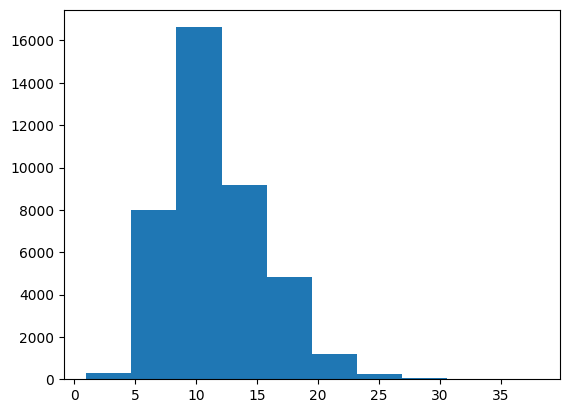

In [ ]:
#Total Words
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer("basic_english")
b = []
for i in caption:
  a = tokenizer(i)
  b.append(len(a))
print(f'Total Words: {sum(b)}')
print(f'Average words per Caption: {np.mean(b)}')
print(f'Maximum caption length: {max(b)}')
print(f'Minimum caption length: {min(b)}')
plt.hist(b)

In [ ]:
image_path = '/content/image/Flicker8k_Dataset'

min_width = float('inf')
min_height = float('inf')
max_width = 0
max_height = 0
min_img_path = None
max_img_path = None

for filename in os.listdir(image_path):
  file_path = os.path.join(image_path, filename)
  image = Image.open(file_path)
  width, height = image.size

  if width * height < min_width * min_height:
    min_width = width
    min_height = height
    min_img_path = file_path

  elif width * height > max_width * max_height:
    max_width = width
    max_height = height
    max_img_path = file_path

print(min_img_path)
print(min_width,min_height)

print(max_img_path)
print(max_width,max_height)


/content/image/Flicker8k_Dataset/2629027962_9cc3b46527.jpg
288 191
/content/image/Flicker8k_Dataset/417577408_eb571658c1.jpg
500 500


In [ ]:
max_width = 500
max_height = 500
for filename in os.listdir(image_path):
  file_path = os.path.join(image_path, filename)
  image = Image.open(file_path)
  width, height = image.size

    elif width * height > max_width * max_height:
    max_width = width
    max_height = height
    max_img_path = file_path

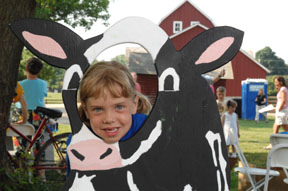

In [ ]:
Image.open(min_img_path)


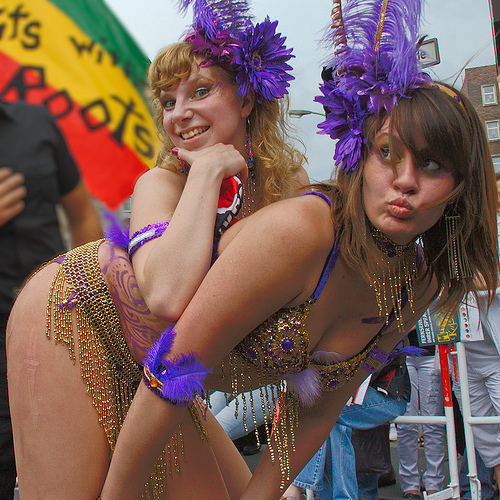

In [ ]:
Image.open(max_img_path)

## Custom dataset

In [ ]:
class CaptionTransform:
    def __init__(self, caption_file):
        captions = self._load_captions(caption_file)
        self.tokenizer = get_tokenizer('basic_english')
        self.vocab = build_vocab_from_iterator(map(self.tokenizer, captions),
                                               specials=['<pad>', '<unk>', '<sos>', '<eos>'])
        self.vocab.set_default_index(self.vocab['<unk>'])
        torch.save(self.vocab, 'vocab.pt')

    def __call__(self, caption):
        indices = self.vocab(self.tokenizer(caption))
        indices = self.vocab(['<sos>']) + indices + self.vocab(['<eos>'])
        target = torch.LongTensor(indices)
        return target

    def __repr__(self):
        return f"""CaptionTransform([
          _load_captions(),
          toknizer('basic_english'),
          vocab(vocab_size={len(self.vocab)})
          ])
          """

    def _load_captions(self, caption_file):
        captions = []
        with open(caption_file) as f:
            for line in f:
                _, caption = line.strip().split("\t")
                captions.append(caption)
        return captions

In [ ]:
caption_transform = CaptionTransform('/content/text/Flickr8k.token.txt')
print(caption_transform)
print(len(caption_transform.vocab))

CaptionTransform([
          _load_captions(),
          toknizer('basic_english'),
          vocab(vocab_size=8915)
          ])
          
8915


In [ ]:
transform_image = transforms.Compose([transforms.ToTensor()])

In [ ]:
class Flickr8k(Dataset):
    def __init__(self, text_path, captions_file, phase, target_transform=None, transform=None):
        self.target_transform = target_transform
        self.transform = transform
        self.captions = []
        self.image_name_captions = []
        self.image_name_captions1 = [self.image_name_captions, self.captions]

        # read images
        self.images_path = (f'{text_path}/Flickr_8k.{phase}Images.txt')
        imgs_file = open(self.images_path)

        self.images_path = [f'/content/image/Flicker8k_Dataset/{line.strip()}'
                            for line in imgs_file]
        self.image_names2 = [re.split('/content/image/Flicker8k_Dataset/', img)[1]
                             for img in self.images_path]

        # read captions
        caps_file = open(captions_file)
        lines = caps_file.readlines()
        for line in lines:
          line = line.strip()
          parts = re.split('\t', line)
          self.image_n =  (re.split('#', parts[0])[0])
          if self.image_n in self.image_names2:
              self.image_name_captions.append(self.image_n)
              self.captions.append(parts[1])

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        img = self.image_name_captions1[0][idx]
        img = os.path.join('/content/image/Flicker8k_Dataset/',img)
        img = Image.open(img).convert('RGB')
        if self.transform is not None:
            image = self.transform(img)

        caption = self.image_name_captions1[1][idx]
        if self.target_transform is not None:
          target = self.target_transform(caption)
        return image, target

In [ ]:
F = Flickr8k('/content/text','/content/text/Flickr8k.token.txt','train',
             target_transform = caption_transform, transform=transform_image)

In [ ]:
len(F)

30000

tensor([  2,   4,  30,  11, 117,  12,   7, 748,   5,   3])


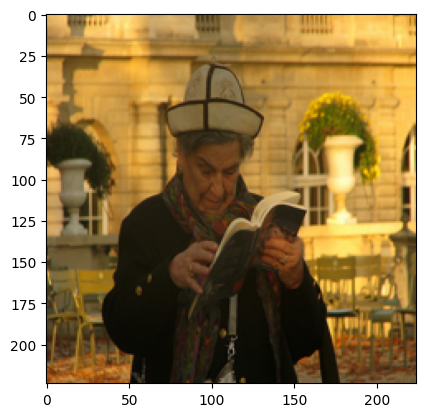

In [ ]:
img, target = F[66]
print(target)
plt.imshow(img.permute(1, 2, 0));

In [ ]:
from numpy.ma.core import resize
class Flickr8k(Dataset):
    def __init__(self, images_path, captions_file, phase, target_transform=None, transform=None):
        self.target_transform = target_transform
        self.transform = transform
        self.captions = []
        self.image_name_captions = []
        self.image_name_captions1 = [self.image_name_captions, self.captions]

        # read images
        self.images_path = (f'{images_path}/Flickr_8k.{phase}Images.txt')
        imgs_file = open(self.images_path)
        self.images_path = [f'/content/image/Flicker8k_Dataset/{line.strip()}'
                            for line in imgs_file]
        self.image_names2 = [re.split('/content/image/Flicker8k_Dataset/', img)[1]
                             for img in self.images_path]

        self.images = [(Image.open(img).convert('RGB')).resize((224,224)) for img in self.images_path]

        # read captions
        caps_file = open(captions_file)
        lines = caps_file.readlines()
        for line in lines:
          line = line.strip()
          parts = re.split('\t', line)
          self.image_n =  (re.split('#', parts[0])[0])
          if self.image_n in self.image_names2:
              self.image_name_captions.append(self.image_n)
              self.captions.append(parts[1])

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform is not None:
            image = self.transform(img)

        caption = self.image_name_captions1[1][idx]
        if self.target_transform is not None:
          target = self.target_transform(caption)
        return image, target

In [ ]:
train_transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

eval_transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

root = '/content/text'
ann_file = '/content/text/Flickr8k.token.txt'

caption_transform = CaptionTransform(ann_file)

train_set = Flickr8k(root, ann_file, 'train', caption_transform, train_transform)
valid_set = Flickr8k(root, ann_file, 'dev', caption_transform, eval_transform)
test_set = Flickr8k(root, ann_file, 'test', caption_transform, eval_transform)

len(train_set), len(valid_set), len(test_set)

(30000, 5000, 5000)

## Define a dataloader

In [ ]:
def collate_fn(batch):
  if len(batch[0]) == 2:
      x_batch, y_batch = zip(*batch)
      x_batch = torch.stack(x_batch)
      y_batch = pad_sequence(y_batch, batch_first=True, padding_value=caption_transform.vocab['<pad>'])
      return x_batch, y_batch
  else:
    x_batch, x_raw, captions = zip(*batch)
    x_batch = torch.stack(x_batch)
    return x_batch, x_raw, captions

In [ ]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                          collate_fn=collate_fn, num_workers=2, pin_memory= True)
valid_loader = DataLoader(valid_set, batch_size=batch_size*2,
                          collate_fn=collate_fn, num_workers=2, pin_memory= True)
test_loader = DataLoader(test_set, batch_size=batch_size*2,
                         collate_fn=collate_fn, num_workers=2, pin_memory= True)

In [ ]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128, 23]))

# **Model**

In [ ]:
class EncoderCNN(nn.Module):
  def __init__(self, embed_size):
    super(EncoderCNN, self).__init__()

    # Load a pre-trained ResNet model
    self.resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    self.resnet.requires_grad_(False)
    feature_size = self.resnet.fc.in_features

    # Remove the classification layer
    self.resnet.fc = nn.Identity()

    # Add linear layer to transform extracted features to the embedding size
    self.linear = nn.Linear(feature_size, embed_size)
    self.bn = nn.BatchNorm1d(embed_size)

  def forward(self, images):
    self.resnet.eval()
    with torch.no_grad():
      features = self.resnet(images)
    features = self.bn(self.linear(features))
    return features

In [ ]:
encoder_temp = EncoderCNN(embed_size=300)
# encoder_temp(x_batch).shape

In [ ]:
num_trainable_params(encoder_temp)

In [ ]:
class DecoderRNN(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size, num_layers, dropout_embd, dropout_rnn, max_seq_length=20):
    super(DecoderRNN, self).__init__()

    self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=caption_transform.vocab['<pad>'])
    self.dropout_embd = nn.Dropout(dropout_embd)

    self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, dropout=dropout_rnn, batch_first=True)

    self.linear = nn.Linear(hidden_size, vocab_size)
    self.max_seq_length = max_seq_length

    self.init_weights()

  def init_weights(self):
      self.embedding.weight.data.uniform_(-0.1, 0.1)
      self.linear.bias.data.fill_(0)
      self.linear.weight.data.uniform_(-0.1, 0.1)

  def forward(self, features, captions):
    embeddings = self.dropout_embd(self.embedding(captions[:, :-1]))
    inputs = torch.cat((features.unsqueeze(1), embeddings), dim=1)
    outputs, _ = self.lstm(inputs)
    outputs = self.linear(outputs)
    return outputs

In [ ]:
decoder_temp = DecoderRNN(embed_size=300, hidden_size=500,
                          vocab_size=len(caption_transform.vocab),
                          num_layers=2,
                          dropout_embd=0.5,
                          dropout_rnn=0.5)
decoder_temp

In [ ]:
features_temp = encoder_temp(x_batch)
decoder_temp(features_temp, y_batch).shape

In [ ]:
num_trainable_params(decoder_temp)

In [ ]:
class ImageCaptioning(nn.Module):

  def __init__(self, embed_size, hidden_size, vocab_size, num_layers,
               dropout_embd, dropout_rnn, max_seq_length=20):
    super(ImageCaptioning, self).__init__()
    self.encoder = EncoderCNN(embed_size)
    self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers,
                              dropout_embd, dropout_rnn, max_seq_length)

  def forward(self, images, captions):
    features = self.encoder(images)
    outputs = self.decoder(features, captions)
    return outputs

In [ ]:
model = ImageCaptioning(300, 500, len(caption_transform.vocab),
                        2, 0.5, 0.5)
model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 120MB/s]


ImageCaptioning(
  (encoder): EncoderCNN(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReL

In [ ]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

In [ ]:
outputs = model(x_batch, y_batch)
outputs.shape

torch.Size([128, 23, 8915])

In [ ]:
outputs.reshape(-1, outputs.shape[-1]).shape, 128*23

(torch.Size([2944, 8915]), 2944)

In [ ]:
y_batch.flatten().shape

torch.Size([2944])

In [ ]:
num_trainable_params(model)

11.364215

# **Config**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
loss_fn = nn.CrossEntropyLoss(ignore_index= caption_transform.vocab['<pad>'])
metric = None

In [ ]:
if wandb_enable:
  wandb_enable.login(key='...........................')

# **Train**

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  if metric: metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs, targets)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

      nn.utils.clip_grad.clip_grad_norm_(model.parameters(), max_norm=clip)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      if metric:
        metric.update(outputs, targets)
        metric_train_val = metric.compute().item()
      else:
        metric_train_val = None

      tepoch.set_postfix(loss=loss_train.avg, metric=metric_train_val)

    return model, loss_train.avg, metric_train_val

# **Evaluation**

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  if metric: metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs, targets)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())
      loss_eval.update(loss.item(), n=len(targets))

      if metric: metric(outputs, targets)

  return loss_eval.avg, metric.compute().item() if metric else None

# **Training Process**

## Main Loop

In [ ]:
torch.cuda.empty_cache()

🔰 train dataloader.

In [ ]:
set_seed(seed)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                          collate_fn=collate_fn, num_workers=2, pin_memory= True)

🔰 model.

In [ ]:
set_seed(seed)
model = ImageCaptioning(embed_size, hidden_size, len(caption_transform.vocab), num_layers,
                        dropout_embd, dropout_rnn, max_seq_length).to(device)

In [ ]:
model = torch.load('/content/model.pt')

🔰 optimizer and Set learning rate and weight decay.

In [ ]:
set_seed(seed)
lr = .125
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

🔰 Initialize `wandb`

In [ ]:
if wandb_enable:
  wandb_enable.init(
      project='image-captioning',
      name=wandb_arg_name,
      config={
          'lr': lr,
          'momentum': momentum,
          'batch_size': batch_size,
          'clip': clip,
      }
  )

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch+1)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_loader,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = None')
  print()

  if wandb_enable:
    wandb_enable.log({"metric_train": metric_train, "loss_train": loss_train,
                "metric_valid": metric_valid, "loss_valid": loss_valid})

  epoch_counter += 1

Epoch 1: 100%|██████████| 235/235 [03:44<00:00,  1.05batch/s, loss=4.44, metric=None]


Model Saved!
Valid: Loss = 3.485, Metric = None



Epoch 2: 100%|██████████| 235/235 [03:58<00:00,  1.01s/batch, loss=3.25, metric=None]


Model Saved!
Valid: Loss = 3.183, Metric = None



Epoch 3: 100%|██████████| 235/235 [03:49<00:00,  1.02batch/s, loss=3.01, metric=None]


Model Saved!
Valid: Loss = 3.035, Metric = None



Epoch 4: 100%|██████████| 235/235 [03:49<00:00,  1.02batch/s, loss=2.88, metric=None]


Model Saved!
Valid: Loss = 2.949, Metric = None



Epoch 5: 100%|██████████| 235/235 [03:44<00:00,  1.05batch/s, loss=2.77, metric=None]


Model Saved!
Valid: Loss = 2.924, Metric = None



Epoch 6: 100%|██████████| 235/235 [03:36<00:00,  1.09batch/s, loss=2.71, metric=None]


Model Saved!
Valid: Loss = 2.882, Metric = None



Epoch 7: 100%|██████████| 235/235 [03:37<00:00,  1.08batch/s, loss=2.65, metric=None]


Model Saved!
Valid: Loss = 2.842, Metric = None



Epoch 8: 100%|██████████| 235/235 [03:37<00:00,  1.08batch/s, loss=2.61, metric=None]


Model Saved!
Valid: Loss = 2.802, Metric = None



Epoch 9: 100%|██████████| 235/235 [03:36<00:00,  1.09batch/s, loss=2.56, metric=None]


Model Saved!
Valid: Loss = 2.794, Metric = None



Epoch 10: 100%|██████████| 235/235 [03:34<00:00,  1.10batch/s, loss=2.54, metric=None]


Model Saved!
Valid: Loss = 2.769, Metric = None



In [ ]:
wandb.finish()
4.54

In [ ]:
model = ImageCaptioning(embed_size, hidden_size, len(caption_transform.vocab), num_layers,
                        dropout_embd, dropout_rnn, max_seq_length).to(device)

In [ ]:
model = torch.load('/content/model_20.pt')

In [ ]:
lr = 1.25
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch+1)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_loader,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = None')
  print()

  if wandb_enable:
    wandb_enable.log({"metric_train": metric_train, "loss_train": loss_train,
                "metric_valid": metric_valid, "loss_valid": loss_valid})

  epoch_counter += 1

Epoch 1: 100%|██████████| 235/235 [05:02<00:00,  1.29s/batch, loss=2.34, metric=None]


Valid: Loss = 2.739, Metric = None



Epoch 2: 100%|██████████| 235/235 [04:58<00:00,  1.27s/batch, loss=2.32, metric=None]


Valid: Loss = 2.739, Metric = None



Epoch 3: 100%|██████████| 235/235 [04:58<00:00,  1.27s/batch, loss=2.31, metric=None]


Model Saved!
Valid: Loss = 2.735, Metric = None



Epoch 4: 100%|██████████| 235/235 [04:57<00:00,  1.27s/batch, loss=2.29, metric=None]


Model Saved!
Valid: Loss = 2.71, Metric = None



Epoch 5: 100%|██████████| 235/235 [04:56<00:00,  1.26s/batch, loss=2.28, metric=None]


Valid: Loss = 2.725, Metric = None



## 🟠 Plot

🔰 Plot learning curves

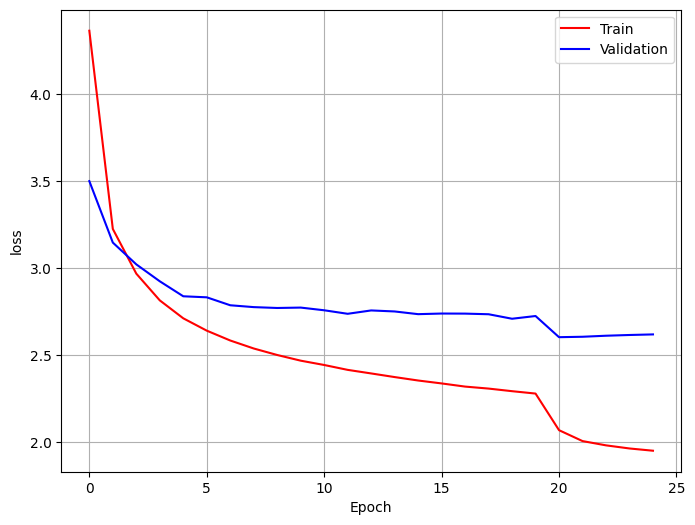

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()